In [51]:
from collections import Counter
import operator
import numpy as np
import scipy
import nltk
from nltk.collocations import *
from nltk.tokenize import word_tokenize
import cPickle
from nltk.tokenize import RegexpTokenizer
import matplotlib.pyplot as plt
import pandas as pd
import copy
from random import shuffle
import gensim
from sklearn.preprocessing import StandardScaler

# Asociación de palabras

## 1) Corpus AP

In [6]:
base_dir = "/Users/lmatayoshi/Documents/Projects/repo-ciencia-datos/tp-6/ap/"
filename = base_dir + "ap.txt"
filename2 = base_dir + "vocab.txt"

In [7]:
with open(filename, "r") as f:
    lines = []
    for line in f:
        lines.append(line)

In [8]:
doc_no = []
texts = []
united_text=[]
for i in range(len(lines)):
    if i % 6 == 1:
        doc_no.append(lines[i].split(" ")[1])
    if i % 6 == 3:
        tokens = nltk.word_tokenize(lines[i])
        tokens = [t.lower() for t in tokens]
        texts.append( tokens )
        united_text=united_text+tokens

In [9]:
texts_dict = dict(zip(doc_no, texts))

## 2) Tamaño del vocabulario

El vocabulario del corpus cuenta con 10473 palabras

In [16]:
with open(filename2, "r") as f:
    vocab = []
    for word in f:
        vocab.append(word.rstrip())
print len(vocab)

10473


## 3) Par más asociado para 500 palabras con más apariciones

In [17]:
general_dicc=[]
for i in range(len(texts)):
    general_dicc.append(Counter(texts[i]))
zeros = [0] * len(vocab)
frecuency_dict = dict(zip(vocab, zeros))
for i in range(len(texts)):
    for word in general_dicc[i].keys():
        if word in frecuency_dict.keys():
            frecuency_dict[word] += general_dicc[i][word]
sorted_frecuency = sorted(frecuency_dict.items(), key=operator.itemgetter(1))
dicc_selected = dict(sorted_frecuency[-500:])

Obtenemos un diccionario con estructura ('palabra': n_apariciones), y lo utilizamos para obtener las 500 palabras que más aparecen

In [28]:
most_repeated_words = dicc_selected.keys()
most_repeated_words

['dollar',
 'month',
 'four',
 'talks',
 'bank',
 'children',
 'issues',
 'young',
 'thursday',
 'iraqi',
 'program',
 'safety',
 'sent',
 'woman',
 'far',
 'fall',
 'continued',
 'condition',
 'school',
 'level',
 'issue',
 'michael',
 'wednesday',
 'large',
 'car',
 'small',
 'force',
 'leaders',
 'japanese',
 'elections',
 'past',
 'go',
 'likely',
 'street',
 'governor',
 'estimated',
 'index',
 'business',
 'richard',
 'shares',
 'current',
 'capital',
 'international',
 'public',
 'told',
 'million',
 'iran',
 'exchange',
 'men',
 'water',
 'met',
 'groups',
 'meet',
 'iraq',
 'change',
 'great',
 'gulf',
 'involved',
 'study',
 'reports',
 'trial',
 'products',
 'analysts',
 'social',
 'action',
 'military',
 'changes',
 'family',
 'africa',
 'private',
 'brought',
 'total',
 'market',
 'troops',
 'working',
 'army',
 'hospital',
 'two',
 'call',
 'strike',
 'today',
 'israel',
 'tax',
 'company',
 'known',
 'cases',
 'effort',
 'women',
 'town',
 'states',
 'rights',
 'local',


Obtenemos score_ngrams para bigramas, restringiendo el cálculo a las 500 con más apariciones. Para ello filtramos las que no pertenecen a dicho conjunto

In [29]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(united_text, window_size=10)
finder.apply_word_filter(lambda w: w not in most_repeated_words)
result = finder.score_ngrams(bigram_measures.pmi)

El par que más se relaciona es wall street con score de 8.19. Incluímos las siguientes 9 tuplas que más se relacionan

In [30]:
result[:10]

[(('wall', 'street'), 8.197046195384113),
 (('yen', 'yen'), 7.796241463379074),
 (('prime', 'minister'), 7.738113731602535),
 (('human', 'rights'), 7.570452888854895),
 (('health', 'care'), 7.509113339060468),
 (('interest', 'rates'), 7.405115974957106),
 (('iraq', 'kuwait'), 7.342251696862347),
 (('quoted', 'saying'), 7.337959774555383),
 (('south', 'africa'), 7.239435911594963),
 (('dollar', 'yen'), 7.219182114830186)]

# Información Léxica

## 1) Tokenización

In [52]:
filename = base_dir + 'on_the_origin'
with open(filename, 'r') as f:
    lines = []
    for line in f:  
        line = line.rstrip()
        if not line == '':
            lines.append(line)
 

In [53]:
origin_united_text=[]
for i in range(len(lines)):
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(lines[i])
    origin_united_text=origin_united_text+tokens

Para tokenizar utilizamos RegexpTokenizer de nltk. Incluímos a continuación los primeros 10 tokens del texto

In [35]:
origin_united_text[:10]

['The',
 'Project',
 'Gutenberg',
 'EBook',
 'of',
 'On',
 'the',
 'Origin',
 'of',
 'Species']

## 2) Autocorrelación

Tal como propone el paper, para calcular la autocorrelación de una palabra a lo largo del texto la estrategia es la siguiente:

1) Generamos una señal sobre todas las posiciones del texto, con valor 1 si la palabra está presente en dicha posición o 0 en caso contrario.

2) Esta señal tiene picos en las posiciones en donde la palabra está presente. Para suavizarla, representamos
la misma señal como suma de gaussianas con centro en las posiciones en donde la palabra está presente. Utilizamos sigma = 50 words, tal como propone el paper.

3) Finalmente calculamos la autocorrelación a partir de la señan suavizada

In [47]:
def g(t, mu, sigma):
    return (1 / np.sqrt(2*np.pi*sigma**2)) * (np.exp(-(t-mu)**2/(2*sigma**2)))

In [48]:
def serie_apariciones(word, origin_united_text):
    apariciones=[]
    for i in origin_united_text:
        if(word==i):
            apariciones.append(1)
        else:
            apariciones.append(0)
    return apariciones

In [49]:
def autocorrelation_fun(word):
    serie=serie_apariciones(word,origin_united_text)
    xs = [1 * x for x in range(1,len(origin_united_text))]
    res = [0] * len(xs)
    x = [x for x in range(-25,25)]
    y = [g(xi, 0, 25) for xi in x]

    for i in range(1,len(origin_united_text)):
        if(serie[i]==1):
            if(i-25 >=0 and i+25 <= len(origin_united_text)):
                for j in range(0,50):
                    res[i+j-25] = res[i+j-25] + y[j]

    plt.figure(figsize= (22,7))
    plt.plot(res)
    plt.ylim(0, 0.05)
    plt.show()

    serie_autocorr = pd.Series(res)
    plt.figure(figsize= (22,7))
    plt.plot([serie_autocorr.autocorr(lag=x) for x in range(1,10000)])
    plt.show()

Realizamos el análisis para las mismas 3 palabras que se utilizan en el paper: 'plants', 'instinct' y 'for'. Para cada una de ellas incluímos el gráfico de aparición de la palabra por posición suavizado a partir de gaussianas y el gráfico de autocorrelación

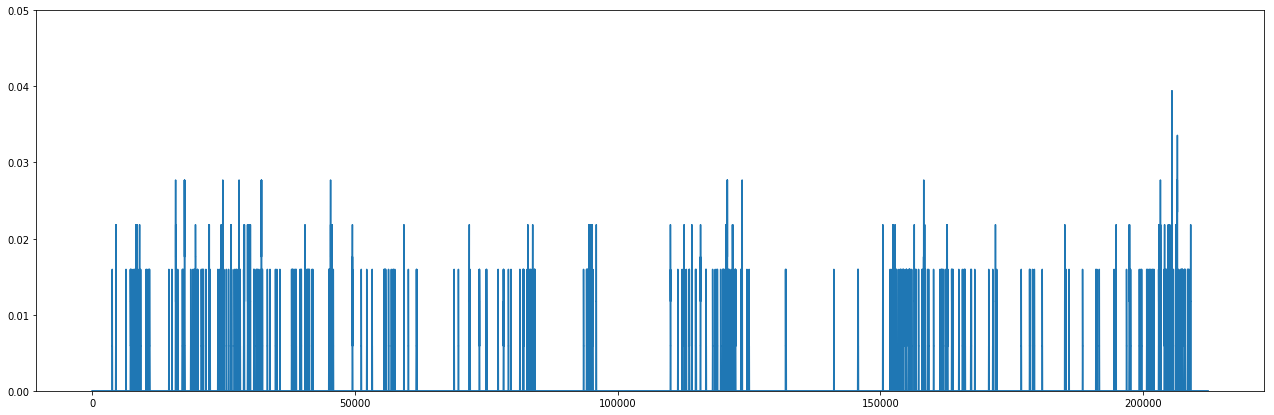

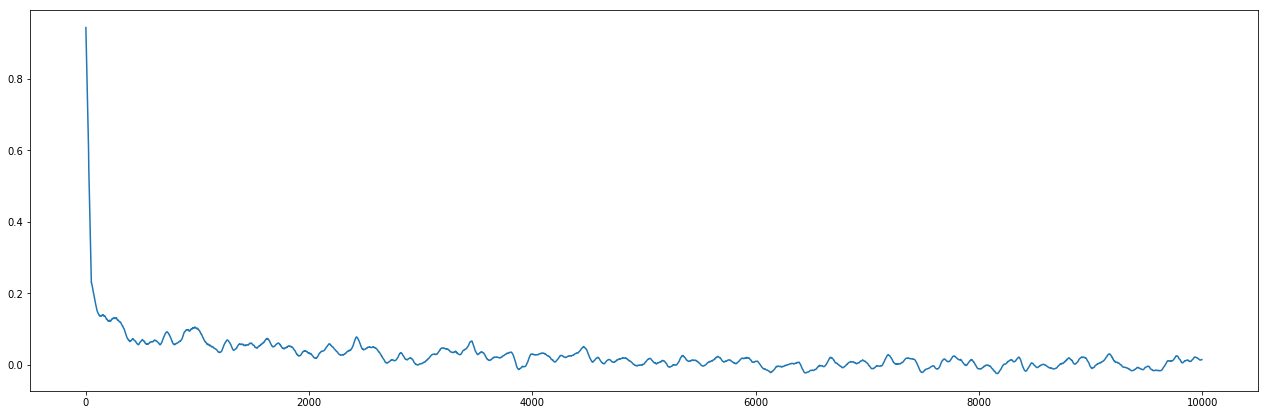

In [50]:
autocorrelation_fun('plants')

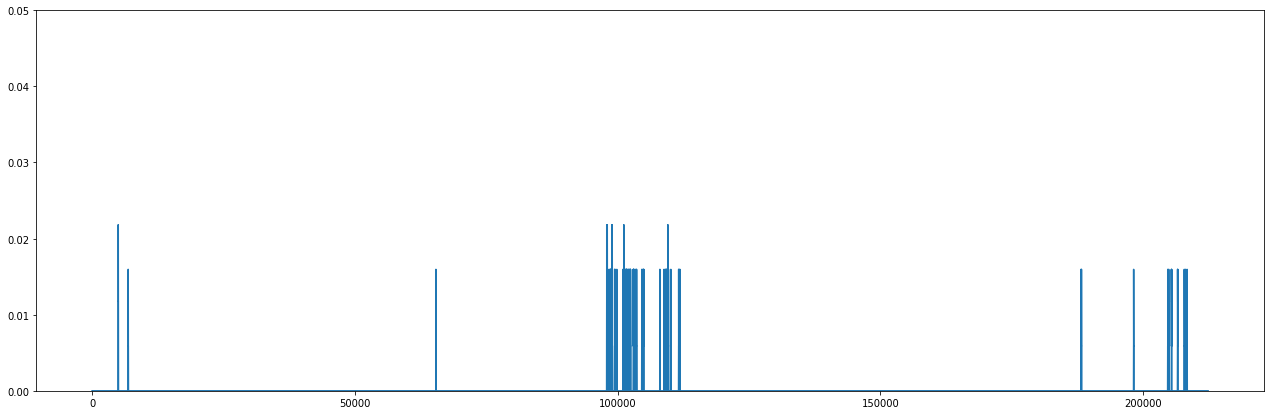

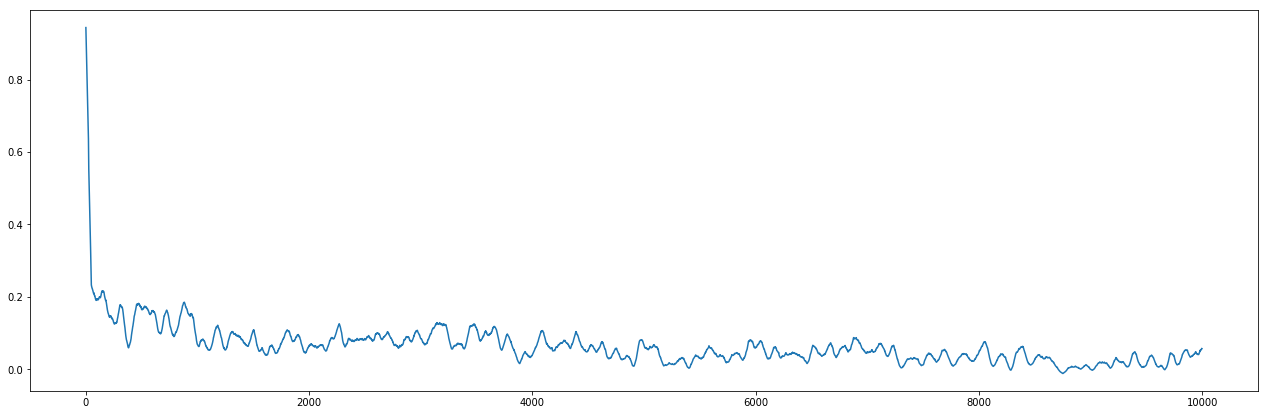

In [223]:
autocorrelation_fun('instinct')

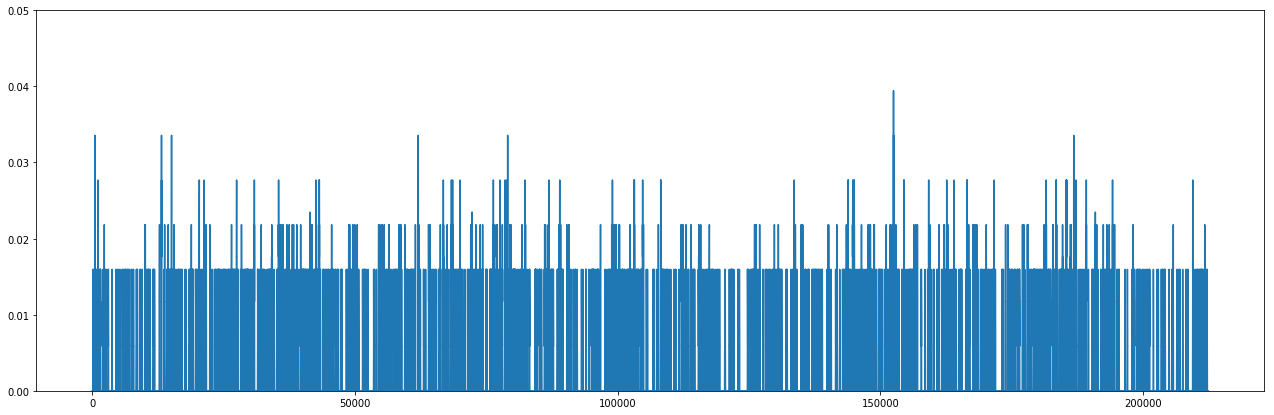

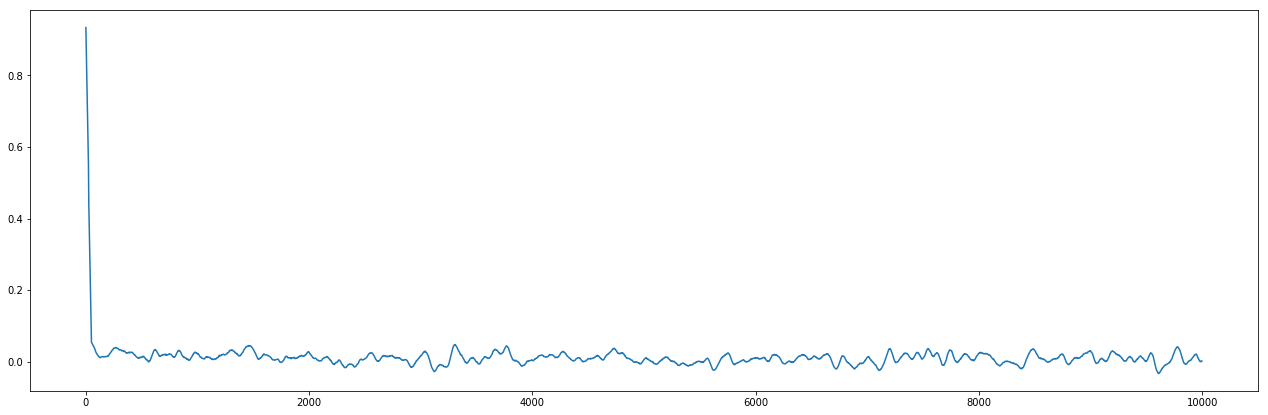

In [222]:
autocorrelation_fun('for')


## 3) 4) Entropía

In [54]:
def calculate_entropy_part(part, word, counter_origin):
    p = Counter(part)[word] / float(counter_origin[word])
    if p == 0:
        return 0
    else:
        return -p * np.log2(p)

Ordenamos el vocabulario del texto en función de cantidad de apariciones de forma creciente

In [56]:
counter_origin = Counter(origin_united_text)
randomized_origin = copy.deepcopy(origin_united_text)
shuffle(randomized_origin)
sorted_frecuency_origin = sorted(counter_origin.items(), key=operator.itemgetter(1))

Y seleccionamos un conjunto de palabras que abarca todo el rango de frecuencias

In [58]:
step = int(len(sorted_frecuency_origin)/100.0)
selected_words = []
for i in range(100):
    selected_words.append(sorted_frecuency_origin[i * step][0])
selected_words.append(sorted_frecuency_origin[-100][0])
selected_words.append(sorted_frecuency_origin[-75][0])
selected_words.append(sorted_frecuency_origin[-50][0])
selected_words.append(sorted_frecuency_origin[-25][0])
selected_words.append(sorted_frecuency_origin[-20][0])
selected_words.append(sorted_frecuency_origin[-15][0])
selected_words.append(sorted_frecuency_origin[-10][0])
selected_words.append(sorted_frecuency_origin[-5][0])
selected_words.append(sorted_frecuency_origin[-1][0])

In [215]:
frecuencies = [counter_origin[word] for word in selected_words]

Para calcular la entropía, separamos el texto en partes de 3000 palabras tomando la sugerencia del paper. "The maximal information values occur at a scale of approximately 3000 words for The Origin of the Species".

In [216]:
len_part = 3000
n_iters = int(len(origin_united_text)/float(len_part)) + 1

In [204]:
def plot_entropy(text, color, label):
    entropy_dict = dict(zip(selected_words, [0] * len(selected_words)))
    parts = []
    for i in range(n_iters):
        actual_part = text[i*len_part:(i+1)*len_part]
        parts.append(actual_part)
    for word in selected_words:
        word_entropy = 0
        for part in parts:
            word_entropy += calculate_entropy_part(part, word, counter_origin)
        entropy_dict[word] = word_entropy
    entropies = [entropy_dict[word] for word in selected_words]
    plt.semilogx(frecuencies, entropies, marker='o', linestyle="", color=color, label=label)

Plotamos la entropía para el conjunto de palabras seleccionadas, tanto para el texto original como para el randomizado

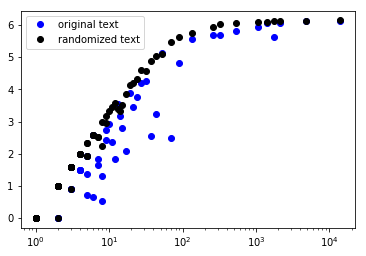

In [206]:
plot_entropy(origin_united_text, "blue", "original text")
plot_entropy(randomized_origin, "black", "randomized text")
plt.legend()
plt.show()

# Word embeddings, distancia semántica, WordNet

## 1) Rendimiento de LSA y Word2Vec para WordSim353

Realizamos el análisis para los pares de palabras listados en WordSim353 versión agreed. Entre ellas, tomamos las 20 con score más alto.

Para obtener los valores correspondientes al método LSA utilizamos http://lsa.colorado.edu/, One-To-Many-Comparison que permite obtener la similaridad para terms-terms (palabras en este caso).

Para obtener los valores correspondientes a Word2Vec, utilizamos gensim sobre el corpus GoogleNews-vectors-negative300.bin

In [59]:
#model = gensim.models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary=True)  

In [63]:
similarity_filename = "/Users/lmatayoshi/Documents/Projects/repo-ciencia-datos/tp-6/lsa-colorado.txt"

with open(similarity_filename, "r") as f:
    similarity_lines = f.readlines()
    similarity_lines = [line.strip().split() for line in similarity_lines]
    similarity_lines = similarity_lines[:-2]

tuples = [(line[0], line[1]) for line in similarity_lines]
wordsim_values = np.array([float(line[2]) for line in similarity_lines]).reshape(-1,1)
lsa_values = np.array([float(line[3]) for line in similarity_lines]).reshape(-1,1)
word2vec_values = np.array([float(line[4]) for line in similarity_lines]).reshape(-1,1)

base_matrix = wordsim_values
base_matrix = np.hstack((base_matrix, lsa_values))
base_matrix = np.hstack((base_matrix, word2vec_values))

dataframe = pd.DataFrame(base_matrix, index=tuples, columns=["WordSim 353", "LSA colorado", "Word2Vec Google News"])

Resumimos los valores obtenidos para ambas técnicas en el siguiente Dataframe:

In [64]:
dataframe

,WordSim 353,LSA colorado,Word2Vec Google News
"(fuck, sex)",9.44,0.21,0.223392
"(journey, voyage)",9.29,0.43,0.683085
"(midday, noon)",9.29,0.59,0.552741
"(dollar, buck)",9.22,0.03,0.256212
"(money, cash)",9.15,0.22,0.615122
"(coast, shore)",9.10,0.40,0.508367
"(money, currency)",9.04,0.57,0.160101
"(football, soccer)",9.03,0.87,0.731355
"(magician, wizard)",9.02,0.29,0.486350
"(type, kind)",8.97,0.33,0.666641


Finalmente, comparamos visualmente el rendimiento de ambas técnicas a partir de un gráfico. Parece haber una correlación entre los valores. Hay que tener en cuenta sin embargo que los corpus a partir de los cuales fueron obtenidos son distintos (

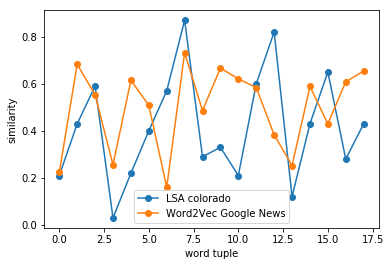

In [65]:
xs = range(len(tuples))
plt.clf()
plt.plot(xs, dataframe['LSA colorado'], label="LSA colorado", marker="o")
plt.plot(xs, dataframe['Word2Vec Google News'], label='Word2Vec Google News', marker="o")
plt.ylabel("similarity")
plt.xlabel("word tuple")
plt.legend()
plt.show()